## Project 4 - NLP with Twitter Sentiments

In [1]:
import pandas as pd
import numpy as np
import string
import re

from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist

from matplotlib import pyplot as plt
import seaborn as sns

## Text Preprocessing

Before modeling, the text needs to be cleaned and processed so that it is suitable for modeling. I'll take out undesired characters and rows from the data, tokenize, and then ultimately vectorize the text.

In [2]:
# Load data and take a first look
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', 
                   encoding='ansi')
df = pd.DataFrame(data)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
# rename columns to shorter names and look at info
df = df.rename(columns={'emotion_in_tweet_is_directed_at':'subject',
                        'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       3291 non-null object
sentiment     9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# get a list of the sentiment categories
sentiments = list(set(df['sentiment']))
sentiments

['No emotion toward brand or product',
 'Positive emotion',
 'Negative emotion',
 "I can't tell"]

In [5]:
# rename the categories to simpler labels
df['sentiment'] = df['sentiment'].replace(to_replace='Positive emotion', value ='positive')
df['sentiment'] = df['sentiment'].replace(to_replace='Negative emotion', value ='negative')
df['sentiment'] = df['sentiment'].replace(to_replace='''I can't tell''', value ='unknown')
df['sentiment'] = df['sentiment'].replace(to_replace='No emotion toward brand or product', value ='neutral')

In [6]:
# drop rows without tweet text and fill renaming nan values with 'none'
df = df.dropna(subset=['tweet_text'])
df = df.fillna('none')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       9092 non-null object
sentiment     9092 non-null object
dtypes: object(3)
memory usage: 284.1+ KB


In [7]:
# function to preprocess single-column dataframe and return a list of the cleaned text
def preprocess(df):
    acceptable = re.compile('[a-zA-Z @]') # regex expression to keep letters and handles

    # make a list of the text that fits with regex above
    cleanedtext = []
    for text in df:
        p = ''.join(acceptable.findall(text)).lower()
        cleanedtext.append(p)
    
    return cleanedtext

In [8]:
# make a n ew column of the clean text
df['cleaned_text'] = preprocess(df['tweet_text'])
df

,tweet_text,subject,sentiment,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,positive,ipad everywhere sxsw link
9089,"Wave, buzz... RT @mention We interrupt your re...",none,neutral,wave buzz rt @mention we interrupt your regula...
9090,"Google's Zeiger, a physician never reported po...",none,neutral,googles zeiger a physician never reported pote...
9091,Some Verizon iPhone customers complained their...,none,neutral,some verizon iphone customers complained their...


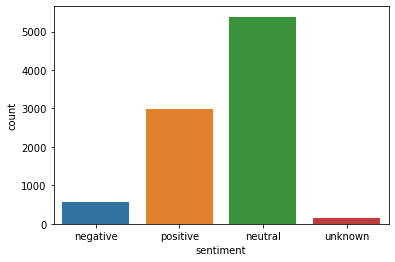

In [9]:
# Look at the counts for each category
ax = sns.countplot(x='sentiment', data=df)

In [10]:
# drop unknown sentiments
df = df[df['sentiment'] != 'unknown']

In [11]:
# tokenize the tweet text
tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
df['tokenized_text'] = df['cleaned_text'].apply(tt.tokenize)

C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# reset the index and review tokenized text
df = df.reset_index(drop=True)
df

,tweet_text,subject,sentiment,cleaned_text,tokenized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."
...,...,...,...,...,...
8931,Ipad everywhere. #SXSW {link},iPad,positive,ipad everywhere sxsw link,"[ipad, everywhere, sxsw, link]"
8932,"Wave, buzz... RT @mention We interrupt your re...",none,neutral,wave buzz rt @mention we interrupt your regula...,"[wave, buzz, rt, we, interrupt, your, regularl..."
8933,"Google's Zeiger, a physician never reported po...",none,neutral,googles zeiger a physician never reported pote...,"[googles, zeiger, a, physician, never, reporte..."
8934,Some Verizon iPhone customers complained their...,none,neutral,some verizon iphone customers complained their...,"[some, verizon, iphone, customers, complained,..."


In [13]:
# input tokenized df and list of words to remove, return the cleaned list
def remove_words(df, to_remove):
    cleaned = []
    for text in df:
        cleaned.append([w for w in text if w not in to_remove])
    return cleaned

In [14]:
# remove English language stopwords and add revisions to new column
stopwords_list = stopwords.words('english')
df['stopped_tokens'] = remove_words(df['tokenized_text'], stopwords_list)

In [15]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [16]:
# Lemmatize stopped tokens and create new column with lemmed words
lemmatizer = WordNetLemmatizer()
lemmed_tokens=[]
for text in df['stopped_tokens']:
    lemmed_tokens.append([lemmatizer.lemmatize(w) for w in text]) 
df['lemmed_tokens'] = lemmed_tokens

In [17]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens,lemmed_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n...","[g, iphone, hr, tweeting, riseaustin, dead, ne..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
# function to remove single-instance words from a list of tweets
def remove_singles(col):
    all_words = []
    for text in col:
        all_words += [w for w in text]
    freqdist = FreqDist(all_words)
    removable_words = [x[0] for x in freqdist.most_common(3)]
    single_words = [x[0] for x in freqdist.most_common() if x[1]==1]
    removable_words += single_words 
    list_of_strings = remove_words(col, removable_words)
    list_of_sentences = [' '.join(q) for q in list_of_strings]
    return list_of_sentences

In [20]:
# Remove single words from current dataframe
X2 = remove_singles(df['lemmed_tokens'])

In [21]:
# function to take a dataframe and return a vectorized dataframe
def vectorize(df):
    vec = CountVectorizer()
    X = vec.fit_transform(df)
    df2 = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
    return df2

In [22]:
# Created vectorized datset and split into train and test data
X = vectorize(X2)
y = df['sentiment']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

## Model 1 - Logistic Regression
Using the vectorized data, first try to see how Logistic Regression performs. 

In [23]:
# columns = vocabulary
# fit with logistic regression
from sklearn.linear_model import LogisticRegression

# Create the model
logreg = LogisticRegression(random_state=42, class_weight='balanced')

# Fit the model
model = logreg.fit(X_train, y_train)

C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
# Generate predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [25]:
# Caclulate accuracy for train data
accuracy = accuracy_score(y_train, y_train_pred)
print('Train Accuracy is: {0}'.format(round(accuracy, 2)))

# Calculate accuracy for test data
accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy is: {0}'.format(round(accuracy, 3)))

Train Accuracy is: 0.87
Test Accuracy is: 0.654


In [26]:
from sklearn.metrics import plot_confusion_matrix

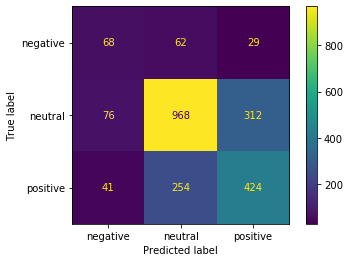

In [27]:
# Plot confusion matrix
plot_confusion_matrix(model, X=X_test, y_true=y_test)

Summary: There is a wide range between the train and test accuracy scores, indicating overfitting. The neutral sentiments are predicted well, however the positive sentiment was only slightly better than guessing, and the negative sentiment was not much better than guessing. 

## Model 1b - Logistic Regression - Optimized

In this iteration, I want to try to get a better performance from the logistic regression model.

In [28]:
# Find the best C value for logistic regression
C = [100, 10, 1, .1, .01, .001]
for c in C:
    logmodel = LogisticRegression(C=c)
    logmodel.fit(X_train, y_train)
    print('C:', c)
    print('Training accuracy:', logmodel.score(X_train, y_train))
    print('Test accuracy:', logmodel.score(X_test, y_test))
    print('')

C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C: 100
Training accuracy: 0.9383766039988063
Test accuracy: 0.6566696508504923



C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C: 10
Training accuracy: 0.9303193076693524
Test accuracy: 0.6651745747538048



C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


C: 1
Training accuracy: 0.8804834377797672
Test accuracy: 0.6875559534467324

C: 0.1
Training accuracy: 0.7709638913757088
Test accuracy: 0.6736794986571173

C: 0.01
Training accuracy: 0.662787227693226
Test accuracy: 0.6486123545210385

C: 0.001
Training accuracy: 0.6014622500746046
Test accuracy: 0.6069829901521934



In [29]:
# Fit the model using the best C value from above, picked 0.01
logmodel = LogisticRegression(C=0.01)
logmodel.fit(X_train, y_train)

# Generate predictions
y_hat_train = logmodel.predict(X_train)
y_hat_test = logmodel.predict(X_test)

In [30]:
# Caclulate accuracy for train data
accuracy = accuracy_score(y_train, y_hat_train)
print('Train Accuracy is: {0}'.format(round(accuracy, 2)))

# Calculate accuracy for test data
accuracy = accuracy_score(y_test, y_hat_test)
print('Test Accuracy is: {0}'.format(round(accuracy, 3)))

Train Accuracy is: 0.66
Test Accuracy is: 0.649


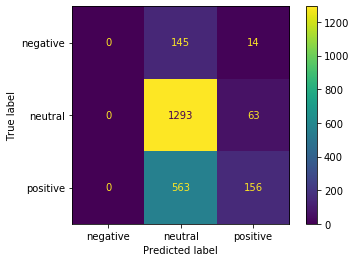

In [31]:
# Plot confusion matrix
plot_confusion_matrix(logmodel, X=X_test, y_true=y_test)
plt.show()

Summary: Overfitting issues solved and neutral and positive sentiment performing better, however negative sentiment performs the worst.

## Model 2 - Decision Tree Classifier

Changing gears, I wanted to see how a decision tree classifier would perform.

In [32]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, recall_score

In [33]:
# Train a DT classifier
classifier = DecisionTreeClassifier(random_state=42)  
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [34]:
# Make predictions for test data
y_hat_train = classifier.predict(X_train) 

# Make predictions for test data
y_hat_test = classifier.predict(X_test)

In [35]:
# Caclulate accuracy for test data
accuracy = accuracy_score(y_train, y_hat_train)
print('Train Accuracy is: {0}'.format(round(accuracy, 3)))

# Caclulate accuracy for test data
accuracy = accuracy_score(y_test, y_hat_test)
print('Test Accuracy is: {0}'.format(round(accuracy, 3)))

Train Accuracy is: 0.958
Test Accuracy is: 0.66


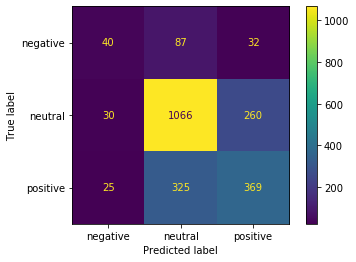

In [36]:
# Plot confusion matrix
plot_confusion_matrix(classifier, X=X_test, y_true=y_test)
plt.show()

Summary: Like Model 1, there is a wide range between the train and test accuracy scores, indicating overfitting. The neutral and positive sentiments are predicted adequtly, but the negative sentiment was worse than guessing. 

## Model 3 - XG Boost

Trying out a gradient boosted model.

In [39]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [40]:
# Instantiate XGBClassifier
xgb_clf = XGBClassifier()

# Fit XGBClassifier
xgb_clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = xgb_clf.predict(X_train)
test_preds = xgb_clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 68.55%
Validation accuracy: 65.26%


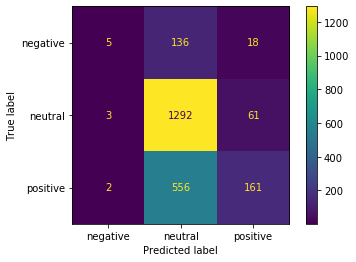

In [41]:
# Look at confusion matrix
plot_confusion_matrix(xgb_clf, X=X_test, y_true=y_test)

Summary: Performs slightly better than Model 1B, but negative class heavily sacrificed.

## Model 3b - Grid Search with XG Boost

Use a grid search in connection with XG Boost to get better performance.

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
# Goal is to increase recall
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4],
    'min_child_weight': [1, 2],
    'subsample': [0.7, 0.8],
    'n_estimators': [10, 20],
    'scale_pos_weight': [6] # impose greater penalties for errors on the minor class, sum(negative instances) / sum(positive instances)
}

In [44]:
# Grid Search based on previous XG Boost classifier
grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', 
                        cv=None, n_jobs=1)

grid_clf.fit(X_train, y_train)
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
grid_clf
print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 4
min_child_weight: 2
n_estimators: 20
scale_pos_weight: 6
subsample: 0.7

Training Accuracy: 66.62%
Validation accuracy: 64.68%


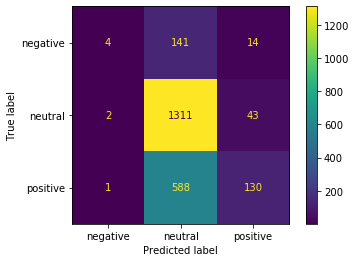

In [45]:
## Look at confusion matrix
plot_confusion_matrix(grid_clf, X=X_test, y_true=y_test)

Summary: Best performance in training vs. validation accuracy and confusion matrix, except for the negative class.